# 第9章 控制抽象
在第7章指出Scala并没有很多内建的控制抽象，因为它提供了让你自己创建控制抽象的能力。在前一章，你学到了函数值。本章将向你展示如何应用函数值来创建新的控制抽象。在这个过程中，你还将学习到柯里化和传名参数。

## 9.1 减少代码重复
所有的函数都能被分解成每次函数调用都一样的公共的部分和每次调用不一样的非公共部分。公共部分是函数体，而非公共部分必须通过实参传入。当你把函数值当作入参的时候，这段算法的非公共部分本身又是另一个算法！每当这样的函数被调用，你都可以传入不同的函数值作为实参，被调用的函数会（在由它选择的时机）调用传入的函数值。这些高阶函数（higher-order function），即那些接收函数作为参数的函数，让你有额外的机会来进一步压缩和简化代码。

高阶函数的好处之一是可以用来创建减少代码重复的控制抽象。例如，假定你在编写一个文件浏览器，而你打算提供API给用户来查找匹配某个条件的文件。首先，你添加了一个机制用来查找文件名是以指定字符串结尾的文件。比如，这将允许用户查找所有扩展名为“.scala”的文件。可以通过在单例对象中定义一个公共的filesEnding方法的方式来提供这样的API，就像这样：

In [2]:
object FileMatcher {
    private def filesHere = (new java.io.File(".")).listFiles
    def fileEnding(query: String) = 
        for(file <- filesHere; if file.getName.endsWith(query))
            yield file
}

defined object FileMatcher

这个filesEnding方法用私有的助手方法filesHere来获取当前目录下的所有文件，然后基于文件名是否以用户给定的查询条件结尾来过滤这些文件。由于filesHere是私有的，filesEnding方法是FileMatcher（也就是你提供给用户的API）中定义的唯一一个能被访问到的方法。

目前为止一切都很完美，暂时都还没有重复的代码。不过到了后来，你决定要让人们可以基于文件名的任意部分进行搜索。当用户记不住他们到底是将文件命名成了phb-important.doc、stupid-phb-report.doc、may2003salesdoc.phb还是别的什么完全不一样的名字，他们只知道名字中某个地方出现了“phb”，这个时候这样的功能就很有用。于是回去给你的FileMatcher API添加了这个函数：

In [3]:
object FileMatcher {
    private def filesHere = (new java.io.File(".")).listFiles
    def fileEnding(query: String) = 
        for(file <- filesHere; if file.getName.endsWith(query))
            yield file
    def fileContaining(query: String) = 
        for(file <- filesHere; if file.getName.contains(query))
            yield file
}

defined object FileMatcher

这个函数跟filesEnding的运行机制没什么两样：搜索filesHere，检查文件名，如果名字匹配则返回文件。唯一的区别是这个函数用的是contains而不是endsWith。

几个月过去了，这个程序变得更成功了。终于，你对某些高级用户提出的想要基于正则表达式搜索文件的请求屈服了。这些喜欢偷懒的用户有着大量拥有上千个文件的巨大目录，他们想做到类似找出所有标题中带有“oopsla”字样的“pdf”文件。为了支持他们，编写了下面这个函数：

In [4]:
object FileMatcher {
    private def filesHere = (new java.io.File(".")).listFiles
    def fileEnding(query: String) = 
        for(file <- filesHere; if file.getName.endsWith(query))
            yield file
    def fileContaining(query: String) = 
        for(file <- filesHere; if file.getName.contains(query))
            yield file
    def fileRegex(query: String) = 
        for(file <- filesHere; if file.getName.matches(query))
            yield file
}

defined object FileMatcher

In [4]:
def fileMatching(query: String, method) = 
    for(file <- filesHere; if file.getName.method(query))
        yield file

(console):1: ':' expected but ')' found.
def fileMatching(query: String, method) = 
                                      ^
(console):2: identifier expected but ';' found.
    for(file <- filesHere; if file.getName.method(query))
                         ^
(console):2: '(' expected but identifier found.
    for(file <- filesHere; if file.getName.method(query))
                              ^
(console):3: illegal start of simple expression
        yield file
                  ^

: 

这种方式在某些动态语言中可以做到，但Scala并不允许像这样在运行时将代码黏在一起。那怎么办呢？

函数值提供了一种答案。虽然不能将方法名像值一样传来传去，但是可以通过传递某个帮你调用方法的函数值来达到同样的效果。在本例中，可以给方法添加一个matcher参数，该参数唯一的目的就是检查文件名是否满足某个查询条件：

In [5]:
object FileMatcher {
    private def filesHere = (new java.io.File(".")).listFiles
    def fileEnding(query: String) = 
        for(file <- filesHere; if file.getName.endsWith(query))
            yield file
    def fileContaining(query: String) = 
        for(file <- filesHere; if file.getName.contains(query))
            yield file
    def fileRegex(query: String) = 
        for(file <- filesHere; if file.getName.matches(query))
            yield file
    def filesMatching(query: String,
        matcher: (String, String) => Boolean) = {
        for (file <- filesHere; if matcher(file.getName, query))
            yield file
    }
}

defined object FileMatcher

在这个版本的方法中，if子句用matcher来检查文件名是否满足查询条件。这个检查具体做什么，取决于给定的matcher。现在，我们来看看matcher这个类型本身。它首先是个函数，因此在类型声明中有个=>符号。这个函数接收两个字符串类型的参数（分别是文件名和查询条件），返回一个布尔值，因此这个函数的完整类型是（String, String） => Boolean。

有了这个新的filesMatching助手方法，可以将前面三个搜索方法进行简化，调用助手方法，传入合适的函数：

In [2]:
object FileMatcher {
    private def filesHere = (new java.io.File(".")).listFiles
    def filesMatching(query: String,
        matcher: (String, String) => Boolean) = {
        for (file <- filesHere; if matcher(file.getName, query))
            yield file
    }
    def fileEnding(query: String) = 
        filesMatching(query, _.endsWith(_))
    def fileContaining(query: String) = 
        filesMatching(query, _.contains(_))
    def fileRegex(query: String) = 
        filesMatching(query, _.matches(_))
}

FileMatcher.fileEnding(".ipynb")

defined object FileMatcher
res1_1: Array[java.io.File] = Array(
  .\1~3-Scala-getting-Started.ipynb,
  .\4-ClassAndObject.ipynb,
  .\5-BasicTypeAndMethod.ipynb,
  .\6-FunctionTypeObject.ipynb,
  .\7-BuiltInControlStructures.ipynb,
  .\8-FunctionsAndClosures.ipynb,
  .\9-ControlAbstraction.ipynb
)

本例中展示的函数字面量用的是占位符语法，这个语法在前一章介绍过，可能对你来说还不是非常自然。所以来澄清一下占位符是怎么用的：filesEnding方法里的函数字面量_.endsWith（_）的含义跟下面这段代码是一样的：
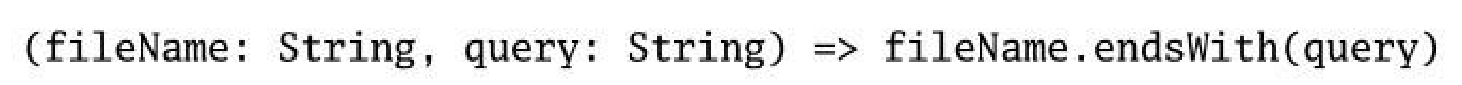

由于filesMatching接收一个要求两个String入参的函数，并不需要显式地给出入参的类型，可以直接写（fileName, query） => fileName. endsWith（query）。因为这两个参数在函数体内分别只用到一次（第一个参数fileName先被用到，然后是第二个参数query），可以用占位符语法来写：_.endsWith（_）。第一个下画线是第一个参数（即文件名）的占位符，而第二个下画线是第二个参数（即查询字符串）的占位符。

这段代码已经很简化了，不过实际上还能更短。注意这里的查询字符串被传入filesMatching后，filesMatching并不对它做任何处理，只是将它传入matcher函数。这样的来回传递是不必要的，因为调用者已经知道这个查询字符串了！完全可以将query参数从filesMatching和matcher中移除，这样就得到示例9.1的代码。

In [3]:
object FileMatcher {
    private def filesHere = (new java.io.File(".")).listFiles
    def filesMatching(query: String,
        matcher: (String) => Boolean) = {
        for (file <- filesHere; if matcher(file.getName))
            yield file
    }
    def fileEnding(query: String) = 
        filesMatching(query, _.endsWith(query))
    def fileContaining(query: String) = 
        filesMatching(query, _.contains(query))
    def fileRegex(query: String) = 
        filesMatching(query, _.matches(query))
}

FileMatcher.fileEnding(".ipynb")

defined object FileMatcher
res2_1: Array[java.io.File] = Array(
  .\1~3-Scala-getting-Started.ipynb,
  .\4-ClassAndObject.ipynb,
  .\5-BasicTypeAndMethod.ipynb,
  .\6-FunctionTypeObject.ipynb,
  .\7-BuiltInControlStructures.ipynb,
  .\8-FunctionsAndClosures.ipynb,
  .\9-ControlAbstraction.ipynb
)

这个例子展示了一等函数是如何帮助你消除代码重复的，没有它们，我们很难做到这样。比如在Java中，你可能会写一个接口，这个接口包含一个接收String返回Boolean的方法，然后创建并传入一个实现了这个接口的匿名内部类的实例给filesMatching。虽然这种做法能够消除掉重复的代码，但同时它也增加了不少甚至更多新的代码。因此，这样的投入带来的收益并不大，你大可以忍受原先的代码重复。

不仅如此，这个示例还展示了闭包是如何帮助我们减少代码重复的。前一例中我们用到的函数字面量，比如_.endsWith（_）和_.containts（_），都是在运行时被实例化成函数值的，它们并不是闭包，因为它们并不捕获任何自由变量。举例来说，在表达式_.endsWith（_）中用到的两个变量都是由下画线表示的，这意味着它们取自该函数的入参。因此，_.endsWith（_）使用了两个绑定变量，并没有使用任何自由变量。相反，在最新的这个例子中，函数字面量_.endsWith（query）包含了一个绑定变量，即用下画线表示的那一个，和一个名为query的自由变量。正因为Scala支持闭包，你才能在最新的这个例子中将query参数从filesMatching中拿掉，从而更进一步简化代码。

## 9.2 简化调用方代码
前面这个例子展示了高阶函数如何帮助我们在实现API时减少代码重复的。高阶函数的另一个重要的用处是将高阶函数本身放在API当中来让调用方代码更加精简。Scala集合类型提供的特殊用途的循环方法是很好的例子。[1]它们当中很多都在第3章的表3.1中列出过，不过现在让我们再看一个例子来搞明白为什么这些方法是很有用的。

我们来看exists，这个方法用于判定某个集合是否包含传入的值。当然可以通过如下方式来查找元素：初始化一个v a r为false，用循环遍历整个集合检查每一项，如果发现要找的内容，就把var设为true。参考下面这段代码，判定传入的List是否包含负数：

In [7]:
def containsNeg(nums: List[Int]): Boolean = {
    var exists = false
    for(num <- nums)
        if(num < 0)
            exists = true
    exists
}

containsNeg(List(1,2,3,4))
containsNeg(List(1,2,-3,4))

defined function containsNeg
res6_1: Boolean = false
res6_2: Boolean = true

不过更精简的定义方式是对传入的List调用高阶函数exists，就像这样：

In [10]:
def containsNeg(nums: List[Int]) = nums.exists(_ < 0)

containsNeg(List(1,2,3,4))
containsNeg(List(1,2,-3,4))

defined function containsNeg
res9_1: Boolean = false
res9_2: Boolean = true

这个e x i s t s方法代表了一种控制抽象。这是Scala类库提供的一个特殊用途的循环结构，并不是像while或for那样是语言内建的。在前一节，高阶函数filesMatching帮助我们在对象FileMatcher的实现中减少了代码重复。这里的exists也带来了相似的好处，不过由于exists是Scala集合API中的公共函数，它减少的是API使用方的代码重复。如果没有exists，而又打算编写一个containsOdd方法来检查某个列表是否包含奇数，可能会这样写：

In [12]:
def containsOdd(nums: List[Int]): Boolean = {
    var exists = false
    for(num <- nums)
        if(num % 2 == 1)
            exists = true
    exists
}

containsOdd(List(2))
containsOdd(List(1,2))

defined function containsOdd
res11_1: Boolean = false
res11_2: Boolean = true

In [13]:
def containsOdd(nums: List[Int]) = nums.exists(_ % 2 == 1)

containsOdd(List(2))
containsOdd(List(1,2))

defined function containsOdd
res12_1: Boolean = false
res12_2: Boolean = true

这个版本的代码体再一次跟对应的containsNeg方法一致（使用exists的版本），除了搜索条件不同。这里的重复代码要少得多，因为所有的循环逻辑都被抽象到exists方法里了。
Scala类库当中还有许多其他循环方法。跟exists一样，它们通常能帮助你缩短代码，如果你能找到机会使用它们。

## 9.3 柯里化
在第1章，我们说过Scala允许你创建新的控制抽象，“感觉就像是语言原生支持的那样”。尽管到目前为止你看到的例子的确都是控制抽象，应该不会有人会误以为它们是语言原生支持的。为了搞清楚如何做出那些用起来感觉更像是语言扩展的控制抽象，首先需要理解一个函数式编程技巧，那就是柯里化（currying）。

一个经过柯里化的函数在应用时支持多个参数列表，而不是只有一个。示例9.2展示了一个常规的，没有经过柯里化的函数，对两个Int参数x和y做加法。

In [14]:
def plainOldSum(x: Int, y: Int) = x + y

plainOldSum(1,2)

defined function plainOldSum
res13_1: Int = 3

与此相反，示例9.3展示了一个相似功能的函数，不过这次是经过柯里化的。跟使用一个包含两个Int参数列表不同，应用这个函数到两个参数列表，每个列表包含一个Int参数。

In [15]:
def curriedSum(x: Int)(y: Int) = x + y

curriedSum(1)(2)

defined function curriedSum
res14_1: Int = 3

这里发生的事情是，当你调用curriedSum，实际上是连着做了两次传统的函数调用。第一次调用接收了一个名为x的Int参数，返回一个用于第二次调用的函数值，这个函数接收一个Int参数y。参考下面这个名为first的函数，从原理上讲跟前面提到的curriedSum的第一次传统函数调用做了相同的事：

In [16]:
def first(x: Int) = (y: Int) => x + y

first(1)

defined function first
res15_1: Int => Int = ammonite.$sess.cmd15$Helper$$Lambda$2570/1588168324@5944283a

把first函数应用到1（换句话说，调用第一个函数，传入1）将交出第二个函数：

In [17]:
val second = first(1)

second: Int => Int = ammonite.$sess.cmd15$Helper$$Lambda$2570/1588168324@2c1dc954

应用第二个函数到2将交出下面的结果：

In [18]:
second(2)

res17: Int = 3

这里的 first和 second函数只是对柯里化过程的示意，它们跟curriedSum并不直接相关。尽管如此，我们还是有办法获取到指向curriedSum的“第二个”函数的引用。这个办法就是通过占位符表示法，在一个部分应用函数表达式中使用curriedSum，就像这样：

In [19]:
val onePlus = curriedSum(1)_

onePlus: Int => Int = ammonite.$sess.cmd18$Helper$$Lambda$2599/1644504026@32145953

代码curriedSum（1）_中的下画线是第二个参数列表的占位符。[2]其结果是一个指向函数的引用，这个函数在被调用时，将对它唯一的Int入参加1后，返回结果：

In [20]:
onePlus(2)

res19: Int = 3

如果想得到一个对它唯一的Int入参加2的函数，可以这样做：

In [21]:
val twoPlus = curriedSum(2)_
twoPlus(2)

twoPlus: Int => Int = ammonite.$sess.cmd20$Helper$$Lambda$2613/1251639208@86fbd25
res20_1: Int = 4

## 9.4 编写新的控制结构
在拥有一等函数的语言中，可以有效地制作出新的控制接口，尽管语言的语法是固定的。你需要做的就是创建接收函数作为入参的方法。

例如下面这个“twice”控制结构，它重复某个操作两次，并返回结果：

In [23]:
def twice(op: Double => Double, x: Double) = op(op(x))

twice(_ + 1, 5)
twice(1 + _, 5)

defined function twice
res22_1: Double = 7.0
res22_2: Double = 7.0

本例中的op类型为Double => Double，意思是这是一个接收一个Double作为入参，返回另一个Double的函数。

每当你发现某个控制模式在代码中多处出现，就应该考虑将这个模式实现为新的控制结构。在本章前面的部分看到了filesMatching这个非常特殊的控制模式，现在来看一个更加常用的编码模式：打开某个资源，对它进行操作，然后关闭这个资源。可以用类似如下的方法，将这个模式捕获成一个控制抽象：

In [4]:
import java.io._

def withPrintWriter(file: File, op: PrintWriter => Unit) = {
    val writer = new PrintWriter(file)
    try{
        op(writer)
    } finally {
        writer.close()
    }
}

import java.io._


defined function withPrintWriter

有了这个方法后，你就可以像这样来使用它：

In [6]:
withPrintWriter(new File("./temp/test.txt"),
               writer => writer.println(new java.util.Date))

使用这个方法的好处是，确保文件在最后被关闭的是withPrintWriter而不是用户代码。因此不可能出现使用者忘记关闭文件的情况。这个技巧被称作贷出模式（loan pattern），因为是某个控制抽象函数，比如withPrintWriter，打开某个资源并将这个资源“贷出”给函数。例如，前一例中的withPrintWriter将一个PrintWriter“贷出”给函数op。当函数完成时，它会表明自己不再需要这个“贷入”的资源。这时这个资源就在finally代码块中被关闭了，这样能确保不论函数是正常返回还是抛出异常，资源都会被正常关闭。

可以用花括号而不是圆括号来表示参数列表，***这样调用方的代码看上去更像是在使用内建的控制结构***。在Scala中，只要有那种只传入一个参数的方法调用，都可以选择使用花括号来将入参包起来，而不是圆括号。

例如，可以不这样写：

In [1]:
println("hello, world!")

hello, world!


而是写成：

In [2]:
println{"hello, world!"}

hello, world!


在第二个例子中，用了花括号而不是圆括号来将println的入参包起来。不过，这个花括号技巧仅对传入单个入参的场景适用。参考下面这个尝试打破这个规则的例子：

In [4]:
val g = "hello, world!"

g.substring(7, 9)

g: String = "hello, world!"
res3_1: String = "wo"

In [4]:
g.substring{7, 9}

(console):1:14 expected "}"
g.substring{7, 9}
             ^

: 

由于你尝试传入两个入参给substring，当试着将这些入参用花括号包起来时，会得到一个错误提示。这个时候需要使用圆括号：

In [5]:
g.substring(7, 9)

res4: String = "wo"

**Scala允许用花括号替代圆括号来传入单个入参的目的是为了让调用方程序员在花括号当中编写函数字面量**。这能让方法用起来更像是控制抽象。拿前面的withPrintWriter举例，在最新的版本中，withPrintWriter接收两个入参，因此你不能用花括号。尽管如此，由于传入withPrintWriter的函数是参数列表中的最后一个，可以用柯里化将第一个File参数单独拉到一个参数列表中，这样剩下的函数就独占了第二个参数列表。示例9.4展示了如何重新定义withPrintWriter。

In [7]:
import java.io._

def withPrintWriter(file: File)(op: PrintWriter => Unit) = {
    val writer = new PrintWriter(file)
    try{
        op(writer)
    } finally {
        writer.close()
    }
}

import java.io._


defined function withPrintWriter

新版本跟老版本的唯一区别在于现在有两个各包含一个参数的参数列表，而不是一个包含两个参数的参数列表。仔细看两个参数之间的部分，在前一个版本的withPrintWriter中（173页），你看到的是...File, op...，而在新的版本中，你看到的是...File）（op...。有了这样的定义，你就可以用更舒服的语法来调用这个方法了：

In [9]:
val file = new File("./temp/date.txt")
withPrintWriter(file){
    writer => writer.println(new java.util.Date)
}

file: File = ./temp/date.txt

在本例中，第一个参数列表，也就是那个包含了一个File入参的参数列表，用的是圆括号。而第二个参数列表，即包含函数入参的那个，用的是花括号。

## 9.5 传名参数
前一节的withPrintWriter方法跟语言内建的控制结构（比如if和while）不同，花括号中间的代码接收一个入参。传入withPrintWriter的函数需要一个类型为PrintWriter的入参，这个入参就是下面代码当中的“writer =>”：
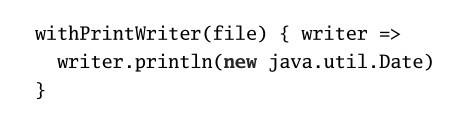
不过假如你想要实现那种更像是if或while的控制结构，没有值需要传入花括号中间的代码，该怎么办呢？为了帮助我们应对这样的场景，Scala提供了传名参数（by-name parameter）。
我们来看一个具体的例子，假定你想要实现一个名为myAssert的断言结构。[3]这个myAssert函数将接收一个函数值作为输入，然后通过一个标记来决定如何处理。如果标记位打开，myAssert将调用传入的函数，验证这个函数返回了true。而如果标记位关闭，那么myAssert将什么也不做。
如果不使用传名参数，你可能会这样来实现myAssert：

In [24]:
var assertionsEnabled = true
def myAssert(predicate: ()=> Boolean) = 
    if(assertionsEnabled && !predicate())
        throw new AssertionError

assertionsEnabled: Boolean = true
defined function myAssert

这个定义没有问题，不过用起来有些别扭：

In [14]:
myAssert(() => 5>3)

In [22]:
myAssert(() => 5<3)

cmd22.sc:1: type mismatch;
 found   : () => Boolean
 required: Boolean
val res22 = myAssert(() => 5<3)
                        ^Compilation Failed

: 

你大概更希望能不在函数字面量里写空的圆括号和=>符号，而是直接这样写：

In [24]:
myAssert(5 > 3)//Won't work, because missing () =>

cmd24.sc:1: type mismatch;
 found   : Boolean(true)
 required: () => Boolean
val res24 = myAssert(5 > 3)
                       ^Compilation Failed

: 

In [22]:
//以上这个函数，我觉得直接这样定义也可以
var assertionsEnabled = true
def myAssert(predicate: Boolean) = 
    if(assertionsEnabled && !predicate)
        throw new AssertionError

assertionsEnabled: Boolean = true
defined function myAssert

In [20]:
myAssert(5>3)

In [21]:
myAssert(5<3)

: 

传名参数就是为此而生的。要让参数成为传名参数，需要给参数一个以=>开头的类型声明，而不是（） =>。例如，可以像这样将myAssert的predicate参数转成传名参数：**把类型“（） => Boolean”改成“=>Boolean”**。示例9.5给出了具体的样子：

In [40]:
var assertionsEnabled = true
def byNameAssert(predicate: => Boolean) = 
    if(assertionsEnabled && !predicate)
        throw new AssertionError

assertionsEnabled: Boolean = true
defined function byNameAssert

In [28]:
byNameAssert(5 > 3)

In [30]:
byNameAssert(5 < 3)

: 

对传名（by-name）类型而言，空的参数列表，即（），是去掉的，这样的类型只能用于参数声明，并不存在传名变量或传名字段。

***你可能会好奇为什么不能简单地用老旧的Boolean来作为其参数的类型声明，就像这样：***

In [33]:
var assertionsEnabled = true
def boolAssert(predicate: Boolean) = 
    if(assertionsEnabled && !predicate)
        throw new AssertionError

assertionsEnabled: Boolean = true
defined function boolAssert

这种组织方式当然也是合法的，boolAssert用起来也跟之前看上去完全一样：

In [35]:
boolAssert(5 > 3)

In [36]:
boolAssert(5 < 3)

: 

**不过，这两种方式有一个显著的区别需要注意**。由于boolAssert的参数类型为Boolean，在boolAssert（5 > 3）圆括号中的表达式将“先于”对boolAssert的调用被求值。而由于byNameAssert的predicate参数类型是=> Boolean，在byNameAssert（5 > 3）的圆括号中的表达式在调用byNameAssert之前并不会被求值，而是会有一个函数值被创建出来，这个函数值的apply方法将会对5 > 3求值，传入byNameAssert的是这个函数值。

**因此，两种方式的区别在于如果断言被禁用，你将能够观察到boolAssert的圆括号当中的表达式的副作用，而用byNameAssert则不会。例如，如果断言被禁用，那么我们断言“x / 0 == 0”的话，boolAssert会抛异常：**

In [46]:
val x = 5
var assertionsEnabled = false
def boolAssert(predicate: Boolean) = 
    if(assertionsEnabled && !predicate)
        throw new AssertionError

boolAssert(x/0 == 0)

: 

而对同样的代码用byNameAssert来做断言的话，不会有异常抛出:

In [47]:
val x = 5
var assertionsEnabled = false
def byNameAssert(predicate: => Boolean) = 
    if(assertionsEnabled && !predicate)
        throw new AssertionError

byNameAssert(x / 0 == 0)

x: Int = 5
assertionsEnabled: Boolean = false
defined function byNameAssert

## 9.6 结语
本章向你展示了如何基于Scala对函数的丰富支持来构建控制抽象。可以在代码中使用函数来提炼出通用的控制模式，也可以利用Scala类库提供的高阶函数来复用那些所有程序员代码都适用的公共控制模式。我们还探讨了如何使用柯里化和传名参数让你自己的高阶函数用起来语法更加精简。

在前一章和本章，你已经了解到关于函数的大量信息。接下来的几章我们将回到Scala中那些更加面向对象的功能特性做进一步讲解。

________________________________________
[1].这些特殊用途的循环方法是在特质Traversable中定义的，List、Set和Map都扩展自这个特质。第17章将会对此做更深入的讨论。  
[2].在前一章，当我们对传统方法使用占位符表示法时，比如println _，需要在方法名和下画线之间放一个空格。在本例中不需要这样做，因为println_是一个合法的Scala标识符，但curriedSum（1）_并不是。  
[3].这里我们只能用myAssert而不是assert，因为Scala自己也提供了一个assert，在14.1节会讲到这个。  